In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, LabelBinarizer

In [2]:
data = pd.read_csv('datasets/housing/housing.csv')

data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Okay we can see the data has some information about the types of houses, the population, median income, total bedrooms, etc

We want to use this data to predict the cost of housing (this data is pretty old so will probably not be accurate for today)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that there are some missing values for total_bedrooms

All numerical data except for ocean_proximity

In [4]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We have 5 different possible values, with how many intances of the data fall into those categories

In [5]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


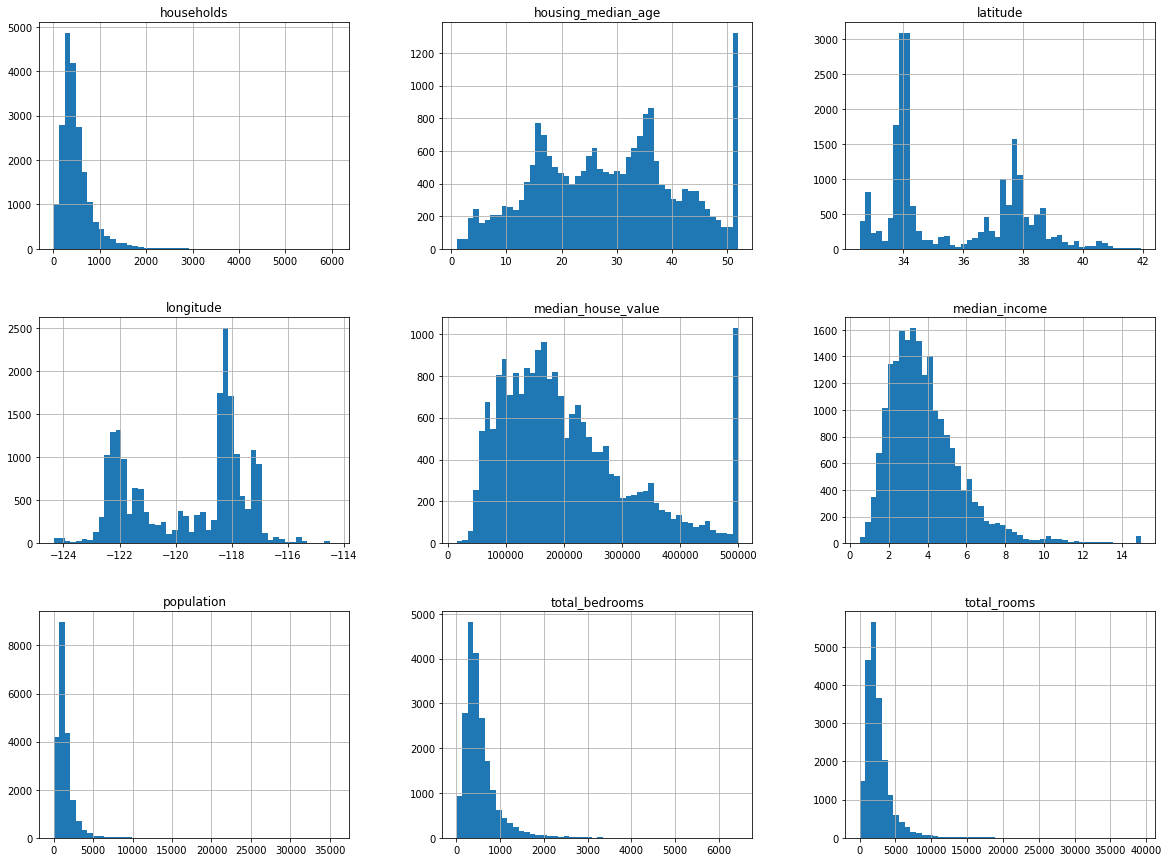

In [6]:
data.hist(bins=50, figsize=(20,15))
plot.show()

It is important to note that the value for income is not in dollars, and value was capped at 15 for higher median incomes and .4999 for lower median incomes. 

Now need to create separate training and test data

In [7]:
random_seed = 7

test_data, train_data = train_test_split(data, test_size=0.2, random_state=random_seed)

print(test_data.info())
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17142 to 16921
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16356 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 4648 to 10335
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4077 non-null float64
population            4128 non-null float64
househ

Median Income is a continuous value, so would be best to create categories of income to help improve the sampling to choose test and training sets. We should try to sample equally from the income categories so random sampling does not cause a bad distribution of test and train data

In [8]:
data['income_cat'] = np.ceil(data['median_income'] / 1.5 )
# create 5 categories and anything outside of the bounds just make a 5
data['income_cat'].where( data['income_cat'] < 5, 5.0, inplace=True)

In [9]:
data['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

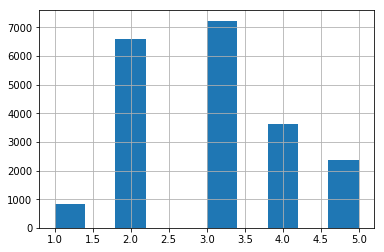

In [10]:
data['income_cat'].hist()
plot.show()

Now we will use stratified sampling to ensure our test and training datasets have a good representation of the different categories of median income, rather than skewing the traing and test data to a particiular level of income. With a dataset this small, and with the distribution of income not being particularly uniform or normal shaped (looking at the histograms from above), it seems smart to ensure we have a good representation of the different categories 

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_index, test_index in split.split(data, data['income_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [12]:
data['income_cat'].value_counts() / len(data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Compare our distribution using stratified sampling to random sampling

In [13]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(data),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [14]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.039971,0.039729,0.364964,-0.243309
2.0,0.318847,0.297481,0.318798,-6.701109,-0.015195
3.0,0.350581,0.358043,0.350533,2.128248,-0.013820
4.0,0.176308,0.188953,0.176357,7.172300,0.027480
5.0,0.114438,0.115552,0.114583,0.973751,0.127011


Can see based on the error that our stratified distribution is much better, so lets keep the train and test sets from the stratified sampling. Now that we have a better sample, we can get rid of the income category we needed

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
data_train = strat_train_set.copy()

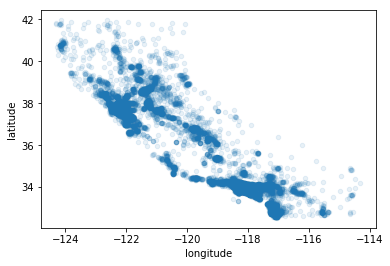

In [17]:
# Visualize the distribution of the data geographically
data_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plot.show()

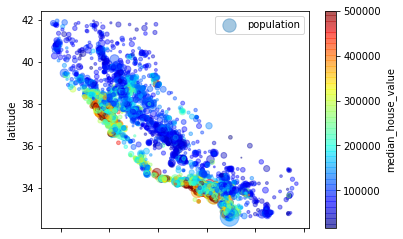

In [18]:
# plot a little differently, include income this time and add color
data_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=data['population']/100, label="population",
             c="median_house_value", cmap=plot.get_cmap('jet'), colorbar=True,
            )
plot.legend()
plot.show()

In [19]:
# let us check the correlation between median income and other attributes
corr_matrix = data.corr()
corr_matrix['median_income'].sort_values(ascending=False)

median_income         1.000000
income_cat            0.902750
median_house_value    0.688075
total_rooms           0.198050
households            0.013033
population            0.004834
total_bedrooms       -0.007723
longitude            -0.015176
latitude             -0.079809
housing_median_age   -0.119034
Name: median_income, dtype: float64

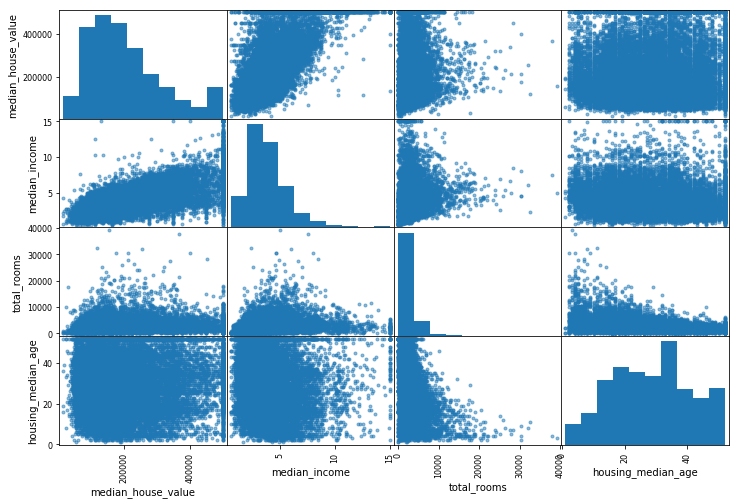

In [20]:
# Only check a couple of the attributes that look promising for scatter matrix
attrs = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(data[attrs], figsize=(12, 8))
plot.show()

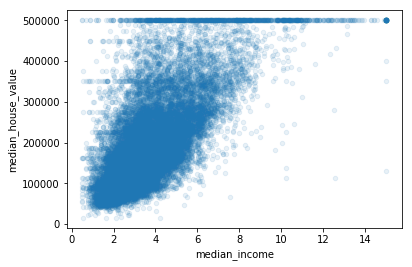

In [21]:
data.plot(kind='scatter', x="median_income", y="median_house_value", 
            alpha=0.1)
plot.show()

In [22]:
# want to know rooms per household 
data['rooms_per_household'] = data['total_rooms']/data['households']

# bedrooms more useful to know in comparison to total rooms
data['bedrooms_per_room'] = data['total_bedrooms']/data['total_rooms']

# want to know population in comparison to households
data['population_per_household'] = data['population']/data['households']

In [23]:
corr_matrix = data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [24]:
# Now we will clean labels from the training data to prepare for model
data = data_train.drop('median_house_value', axis=1)
data_labels = data_train['median_house_value'].copy()

In [25]:
# we need to clean up the missing values from the ocean proximity attribute

median = data["total_bedrooms"].median()
data["total_bedrooms"].fillna(median, inplace=True)

# need to get rid of ocean proximity because it is not a numerical value
data_numerical = data.drop('ocean_proximity', axis=1)

In [26]:
# Imputer will allow us to replace missing values by the median
imputer = Imputer(strategy='median')
imputer.fit(data_numerical)
imputer.statistics_

array([ -118.5    ,    34.26   ,    29.     ,  2125.     ,   435.     ,
        1166.     ,   409.     ,     3.53665])

In [27]:
x = imputer.transform(data_numerical)

In [28]:
data_tr = pd.DataFrame(x, columns=data_numerical.columns)

In [29]:
encoder = LabelEncoder()
housing_cat = data['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 1, 1, ..., 1, 1, 4])

In [30]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [31]:
# One hot encoding instead 
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [32]:
housing_cat_1hot.toarray()

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [33]:
# one hot encoding from a categorical datatype can be done in one step with LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ..., 
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])